# Analysing Tweets from Donald Trump

## Description

We want to analyse Donald Trump's communication on twitter. We have an history of all Donald trump tweets since 01/01/2015 in the form of a text file. Each line of this text file is in the form: text_of_the_tweet,date_of_the_tweet.
Each tweet can be an original tweet or a retweet, each retweet starts with the keyword ‘RT’
We ant to explore this data by using Spark, because our analysis should also be able to apply on very large data sets, for instance to analyze the communication of other public figures.

<img src="Trump_Tweets.png">

## Importing all Libraries used in the analysis

In [1]:
import pyspark
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
import seaborn as sb
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
import atexit
from numpy import array
import numpy as np
import datetime

## Creating a Context for the analyse

In [2]:
sc = pyspark.SparkContext(appName="projet toulouse")

In [3]:
spark = pyspark.sql.SparkSession.builder.appName("Spark-Dataframe-SQL").getOrCreate()

## Data Overview

Importing the tweets text file from the local directory

In [4]:
# INGEST DATA

# RECORD START TIME
timestart = datetime.datetime.now()

# IMPORT FILE FROM PUBLIC BLOB
tls_hse = sc.textFile('trump_tweets_text_date.txt')

The total number of tweets is:

In [5]:
tls_hse.count()

28972

Let's see the 5 first elements of our RDD in order to better observe the structure and chose the way to use this

In [6]:
tls_hse.take(5)

['White House news conference today at 5:30 P.M. Eastern. Thank you!,04-15-2020 20:49:31',
 'We are having very productive calls with the leaders of every sector of the economy who are all-in on getting America back to work and soon. More to come! #MAGA,04-15-2020 19:02:47',
 'My condolences to the Steinbrenner family and the entire @Yankees Organization on the passing of Hank Steinbrenner. He was a friend and will be missed greatly by all! https://t.co/nHsO7Wy0oM,04-15-2020 15:48:05',
 '#ThanksForDelivering @UPS! https://t.co/4Sis7Tme17,04-15-2020 15:39:58',
 'RT @USNavy: Hard at work in #NYC.#USNavy Sailors provide care for trauma emergency and urgent care patients without regard to their #CO…,04-15-2020 15:39:13']

# Data Exploration

Constructing an RDD with the different words used in the tweets

In [7]:
#Getting different words from the tweets

words = tls_hse.flatMap(lambda line: line.split(",")).flatMap(lambda line: line.split()).filter(lambda w: 'https' not in w)

words.take(10)

['White',
 'House',
 'news',
 'conference',
 'today',
 'at',
 '5:30',
 'P.M.',
 'Eastern.',
 'Thank']

### Top 10 Hashtags

Getting the different Hashtags from the dataset and sorting them by number of occurence

In [8]:
#Getting the different Hashtags sorted by counts

tags = words.filter(lambda line : line.startswith('#')).map(lambda word: (word, 1)).reduceByKey(lambda a,b : a+b).sortBy(lambda tuple: tuple[1], ascending = False)
tags.take(10)

[('#Trump2016', 432),
 ('#MakeAmericaGreatAgain', 288),
 ('#MAGA', 247),
 ('#Trump2016"', 153),
 ('#MakeAmericaGreatAgain"', 87),
 ('#CelebApprentice', 85),
 ('#KAG2020', 64),
 ('#CelebrityApprentice', 62),
 ('#AmericaFirst', 60),
 ('#VoteTrump', 56)]

Creating an RDD with the top 10 tags used in orther to plot them in a graph

In [9]:
top_tags = tags.take(10)

In [10]:
#plotting top_10_Hashtags

def barchart1(top_10):
    pd_df = pd.DataFrame(top_10, columns = ['Hashtag','Count']).sort_values('Count', ascending = False) 
    
    plt.figure(figsize = (12,7))
    chart = sb.barplot(data=pd_df, x='Hashtag', y='Count', order=pd_df['Hashtag'])
    chart.set_xticklabels(
    chart.get_xticklabels(),
    rotation = 80,
    horizontalalignment = 'right',
    fontweight = 'light',
    fontsize = 'large',
    )
    
    plt.show()

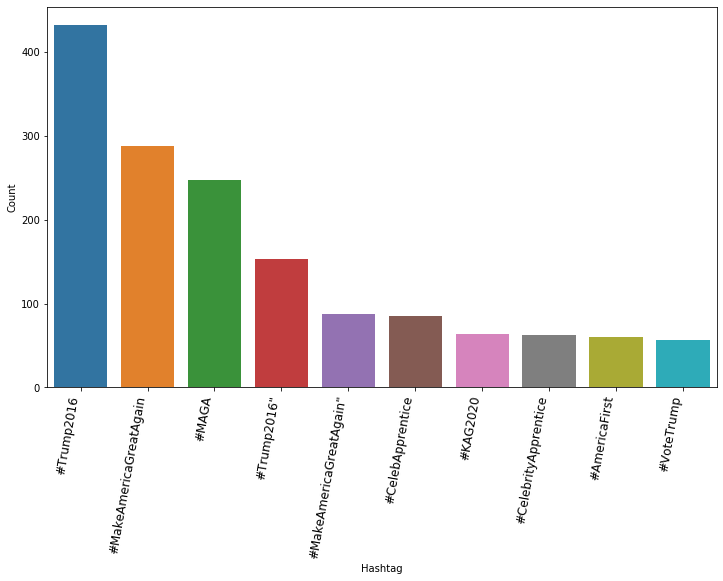

In [11]:
barchart1(top_tags)

We can observe that there are some tags related (Trump and Trump" or MakeAmericaGreatAgain and MAGA) but we will not group them because here we want to show a clear overview of the top concepts

### Top @tags

We are now going to find the top tags in the donald's tweet file

In [12]:
#Getting the different Tags sorted by counts

tag = words.filter(lambda line : line.startswith('@')).map(lambda word: (word, 1)).reduceByKey(lambda a,b : a+b).sortBy(lambda tuple: tuple[1], ascending = False)
tag.take(10)

[('@realDonaldTrump', 3884),
 ('@realDonaldTrump:', 607),
 ('@FoxNews', 539),
 ('@WhiteHouse:', 377),
 ('@foxandfriends', 372),
 ('@CNN', 260),
 ('@ApprenticeNBC', 178),
 ('@GOPChairwoman:', 163),
 ('@nytimes', 151),
 ('@realDonaldTrump"', 148)]

After getting the them ranked, we will use the same function to plot them

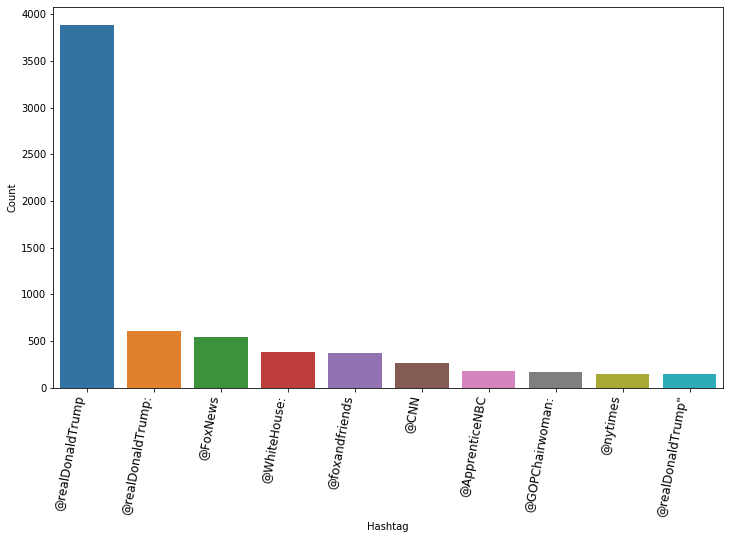

In [13]:
top_tag = tag.take(10)
barchart1(top_tag)

def lower_clean_str(x):
  punc='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
  lowercased_str = x.lower()
  for ch in punc:
    lowercased_str = lowercased_str.replace(ch, '')
  return lowercased_str

l=sc.parallelize(tls_hse)
wlower = l.map(lower_clean_str)
wolower.collect()

#words = words.flatMap(lambda word: wors.lower())

In [14]:
words_kv = words.map(lambda word: (word, 1))
words_kv.take(5)

[('White', 1), ('House', 1), ('news', 1), ('conference', 1), ('today', 1)]

In [15]:
periods = tls_hse.map(lambda line: line.split(",")[-1])
period = periods.take(5000)

###  Extracting top positives words from product reviews 

### First, let's build an RDD dictionnary key-values of positive words

We import them

In [16]:
# we read the positive words

rdd_positive_words = sc.textFile('positive-words.txt')

rdd_positive_words.take(5)

['a+', 'abound', 'abounds', 'abundance', 'abundant']

we map them

In [17]:
# initialize an rdd with key/value for counting each positive word in the file 


rdd_positive_words_kv = rdd_positive_words.map(lambda word: (word, 1))

rdd_positive_words_kv.take(5)

[('a+', 1), ('abound', 1), ('abounds', 1), ('abundance', 1), ('abundant', 1)]

### Now we inner-join them to our kv-dictionnary RDD to obtain all positive words with their counts

In [18]:
positive_words_kv = words_kv.join(rdd_positive_words_kv)

positive_words_kv.take(5)

[('work', (1, 1)),
 ('work', (1, 1)),
 ('work', (1, 1)),
 ('work', (1, 1)),
 ('work', (1, 1))]

In [19]:
# use the mapValues transformation to assign a default count of 1 for each positive word

positive_words_kv = positive_words_kv.mapValues(lambda tuple: 1)

positive_words_kv.take(5)

[('work', 1), ('work', 1), ('work', 1), ('work', 1), ('work', 1)]

Finally we create a list with top 25 positive words in the tweets

In [20]:
# rdd_positive_words_product_count_kv should contain the number of occurences (count) of each positive word in product reviews

positive_words_count_kv = positive_words_kv.reduceByKey(lambda x,y : x+y).sortBy(lambda tuple: tuple[1], ascending=False)

pos = positive_words_count_kv.take(25)
pos

[('great', 2408),
 ('like', 943),
 ('good', 678),
 ('love', 411),
 ('work', 400),
 ('best', 391),
 ('win', 387),
 ('right', 364),
 ('better', 354),
 ('support', 348),
 ('strong', 312),
 ('wonderful', 304),
 ('honor', 304),
 ('well', 276),
 ('thank', 227),
 ('important', 211),
 ('amazing', 203),
 ('incredible', 197),
 ('protect', 187),
 ('won', 182),
 ('nice', 178),
 ('ready', 171),
 ('tough', 170),
 ('proud', 163),
 ('beautiful', 154)]

###  Extracting top negatives words from product reviews 

Same process...

In [21]:
rdd_negative_words = sc.textFile('negative-words.txt')

rdd_negative_words.take(5)

['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable']

In [22]:
# initialize an rdd with key/value for counting each negative word in the file 

rdd_negative_words_kv = rdd_negative_words.map(lambda word: (word, 1))

rdd_negative_words_kv.take(5)

[('2-faced', 1),
 ('2-faces', 1),
 ('abnormal', 1),
 ('abolish', 1),
 ('abominable', 1)]

Finally we create a list with top 25 positive words in the tweets

In [23]:
# rdd_negative_words_product_kv RDD should contain negative words in the product review file

negative_words_count_kv = words_kv.join(rdd_negative_words_kv).mapValues(lambda tuple:tuple[1]).reduceByKey(lambda x,y: x+y).sortBy(lambda tuple: tuple[1], ascending=False)

neg = negative_words_count_kv.take(25)
neg

[('bad', 452),
 ('hard', 373),
 ('illegal', 245),
 ('lost', 186),
 ('crime', 171),
 ('terrible', 168),
 ('phony', 158),
 ('wrong', 138),
 ('failed', 134),
 ('attack', 131),
 ('dishonest', 130),
 ('corrupt', 130),
 ('badly', 128),
 ('worst', 126),
 ('weak', 121),
 ('failing', 114),
 ('horrible', 108),
 ('false', 104),
 ('killed', 97),
 ('problem', 95),
 ('dangerous', 88),
 ('ridiculous', 85),
 ('losing', 78),
 ('lies', 77),
 ('hate', 76)]

###   Visualizing polarized opinions from our tweet file

In [24]:
# the utility function plot_opinion plots a bar chart presenting top positives and top negatives words
# the parameters are list of tuples containing counts from positives and negatives words

from matplotlib import pyplot as plt
import seaborn as sb

import pandas as pd

def plot_opinion(list_positives, list_negatives):
    
    list_1 = [(t[0], t[1], 'positive') for t in list_positives]
    list_2 = [(t[0], t[1], 'negative') for t in list_negatives]
    
     
    list_1.extend(list_2)
    
    
    pd_df = pd.DataFrame({
     'Opinion': [ t[0] for t in list_1 ],
     'Count': [ t[1] for t in list_1 ],
     'polarity': [ t[2] for t in list_1 ]
    }).sort_values('Count', ascending=False)
    
    pd_df['color'] = pd_df.polarity.apply(lambda polarity: 'green' if polarity=='positive' else 'red')
    
    plt.figure( figsize = (15, 8) )
    chart=sb.barplot(data=pd_df, x='Opinion', y='Count', hue='polarity', palette=["blue", "red"], order=pd_df['Opinion'])
    chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=80, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large',
    )
    
    for tick, color in zip(chart.get_xticklabels(), pd_df['color']): 
        tick.set_color(color)
    
    plt.show()

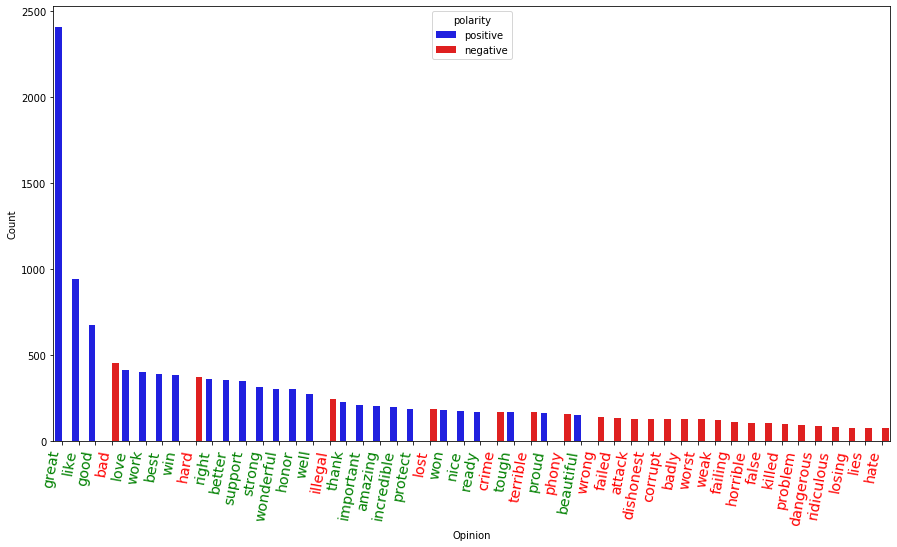

In [25]:
# call the plot_opinion function to plot our product reviews top positives and negatives opinions

plot_opinion(pos, neg)

We observe from this diagram that the top positive words have more impact than the negative ones, because they occur much more in the doc

###  <span style="color:green"> Step 5: Visualizing contextual words from product reviews </span>

In [26]:
# we read our stop words

rdd_stop_words = sc.textFile('stop-words.txt')

rdd_stop_words.take(5)

['a', 'about', 'above', 'across', 'after']

In [27]:
# compute the neutral/contextual words RDD by using rdd_product_words, rdd_positive_words, rdd_negative_words and rdd_stop_words
# neutral words are words in product reviews file, that are not positive words or negative words or stop words
# tip: you can use the subtract transformation on RDD see documentation 
# http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD

contextual_words = words.subtract(rdd_positive_words).subtract(rdd_negative_words).subtract(rdd_stop_words)

contextual_words.take(20)

['family',
 'family',
 'family',
 'family',
 'family',
 'family',
 'family',
 'family',
 'family',
 'family',
 'family',
 'family',
 'family',
 'family',
 'family',
 'family',
 'family',
 'family',
 'family',
 'family']

In [28]:
cld = contextual_words.take(50000)

In [29]:
# use multiple transformations for counting each contextual word in the product review file, sorted in ascending order based 
# on the count

contextual_words_count_ordered = contextual_words.map(lambda word: (word, 1))\
                                                 .reduceByKey(lambda x,y : x+y)\
                                                 .sortBy(lambda tuple: tuple[1], ascending=False)

list_top_contextual_words = contextual_words_count_ordered.take(50)  

list_top_contextual_words

[('I', 5837),
 ('RT', 5811),
 ('@realDonaldTrump', 3884),
 ('The', 3347),
 ('Trump', 2314),
 ('President', 1824),
 ('Thank', 1763),
 ('We', 1625),
 ('people', 1537),
 ('just', 1335),
 ('Democrats', 1220),
 ('Great', 1174),
 ('He', 931),
 ('want', 879),
 ('They', 869),
 ('American', 856),
 ('A', 852),
 ('U.S.', 845),
 ('time', 828),
 ('This', 822),
 ('It', 817),
 ('going', 808),
 ('big', 777),
 ('Hillary', 757),
 ('Fake', 739),
 ('America', 737),
 ('new', 728),
 ('Donald', 694),
 ('New', 666),
 ('News', 662),
 ('GREAT', 638),
 ('United', 638),
 ('said', 637),
 ('doing', 633),
 ('make', 611),
 ('@realDonaldTrump:', 607),
 ('House', 604),
 ('need', 587),
 ('Just', 578),
 ('So', 545),
 ('If', 544),
 ('years', 544),
 ('@FoxNews', 539),
 ('did', 537),
 ('country', 530),
 ('know', 526),
 ('You', 516),
 ('job', 515),
 ('Republican', 511),
 ('Will', 510)]

In [30]:
# the utility function plot_contextual_words plots a bar chart presenting top contextual words
# the parameter are list of tuples containing counts from contextual words

def plot_contextual_words(list_contextual_words):
    
    pd_df = pd.DataFrame({
        'Word':  [ t[0] for t in list_contextual_words ],
        'Count': [ t[1] for t in list_contextual_words ]
    }).sort_values('Count', ascending=False)
    
    plt.figure( figsize = (15, 8) )
    
    chart=sb.barplot(data=pd_df, x='Word', y='Count', order=pd_df['Word'], color='blue')
    
    chart.set_xticklabels(
        chart.get_xticklabels(), 
        rotation=80, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large',
        )
    
    plt.show()

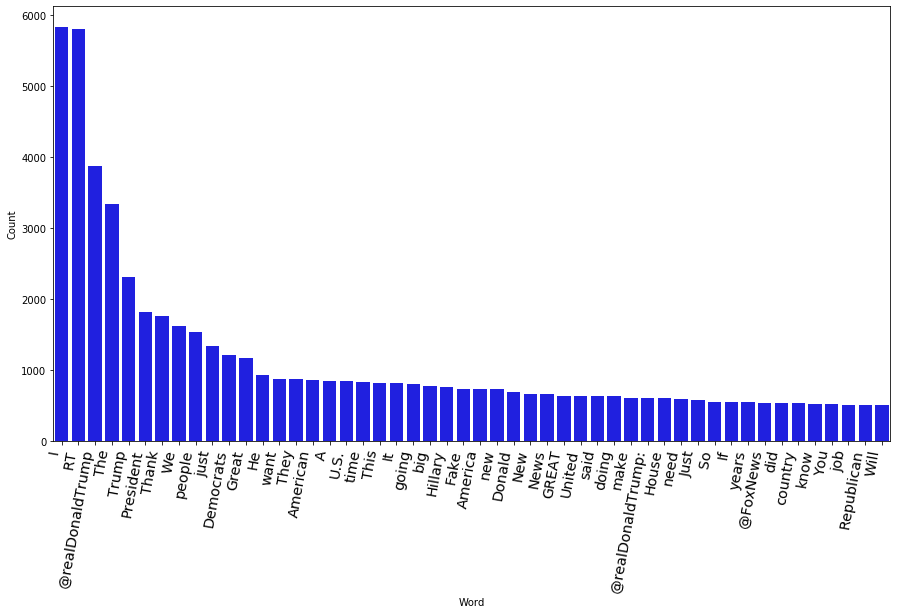

In [31]:
plot_contextual_words(list_top_contextual_words)

### Sentiment score

In [32]:


# Compute the global sentiment score: the total count of positive words (e.g. use rdd_positive_words_product_count_kv) minus
# the total count of negative words (e.g. use rdd_negative_words_product_count_kv)


sentiment_score = positive_words_count_kv.map(lambda tuple: tuple[1]).sum()\
                  - negative_words_count_kv.map(lambda tuple: tuple[1]).sum()

print('The sentiment score of this tweets is : ',sentiment_score)



The sentiment score of this tweets is :  5775


This sentiment score is highly positive, meaning that trump uses to tweet positively 

## Seasonal Analysis

Let's analyse the seasonnality if trumps tweets over the last 5 years. To do this, we need to take into account the trend :

In [33]:
trend = tls_hse.map(lambda line: line.split(",")[-1]).map(lambda line: line.split(" ")[0]).map(lambda line: pd.to_datetime(line)).map(lambda date: (date, 1)).reduceByKey(lambda a,b : a + b).sortBy(lambda tuple: tuple[1], ascending=False)

trend_list=trend.collect()

In [34]:
df = pd.DataFrame(trend_list,columns=['Date','Count']  
    ).sort_values('Date',ascending=True)

This is the trends dataframe from which we have evolution of tweets over time. Now, let's transforme the type of date column into a date type and switwh the 'Date column' as index

In [35]:


# We transforme the type of date column into a date type and switwh the 'Date column' as index
df['Date']=pd.to_datetime(df['Date'])
df.set_index("Date",inplace=True)

df.head()

,Count
Date,
2014-12-31,6
2015-01-01,22
2015-01-02,35
2015-01-03,24
2015-01-04,48


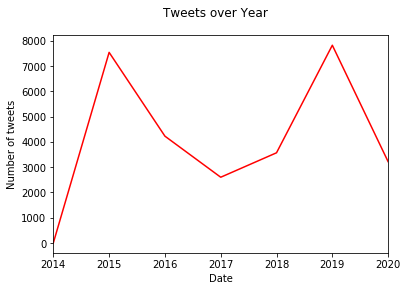

In [36]:


def ploting(df,title="",periode='Y', xlabel='Date', ylabel='Number of tweets'):
    Year=df.Count.resample(periode).sum()
    plt.gca().set(xlabel=xlabel, ylabel=ylabel)
    Year.plot(subplots = True, title=title, color='red')
    plt.show()
ploting(df, title='Tweets over Year',periode='Y')   



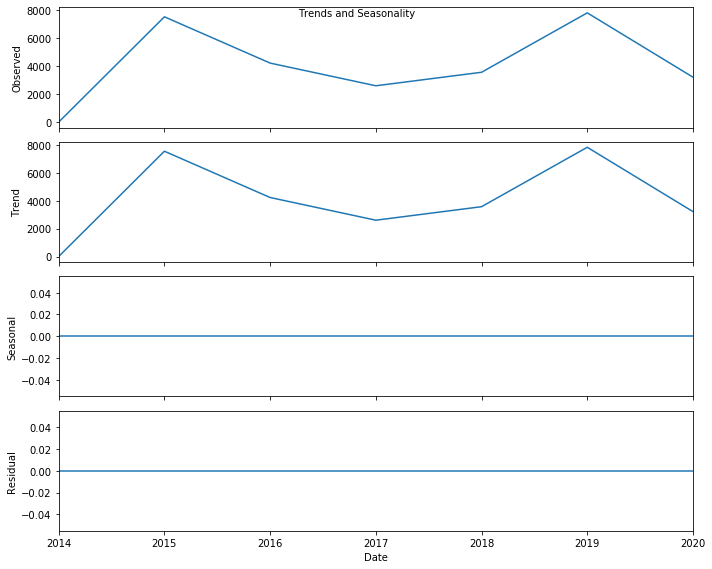

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose
def trend_seasonal(df,model='additive',titlesize="",periode='Y'):
    plt.rcParams.update({'figure.figsize': (10,8)})
    Year=df.Count.resample(periode).sum()
    trend_seasonal= seasonal_decompose(Year, model='additive')
    trend_seasonal.plot().suptitle('Trends and Seasonality', fontsize=titlesize)
    plt.show()
trend_seasonal(df,model='additive',titlesize=10,periode='Y')

From these two graphs the first observation we do is that the curves have two pics, lets replot it on a month scale in orther to beter understand what's going on.

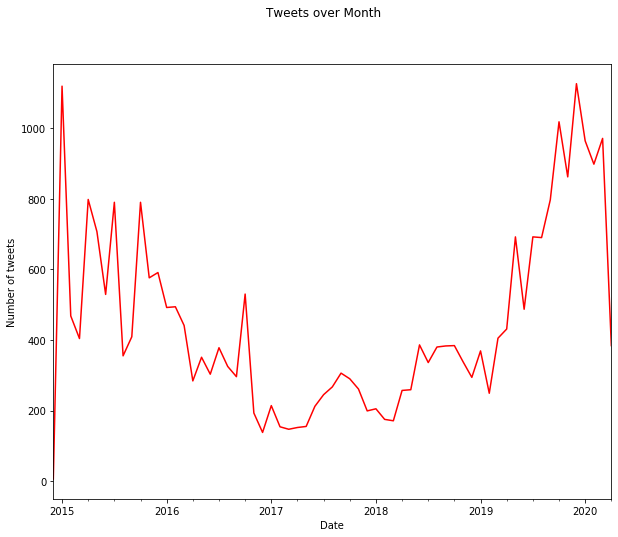

In [38]:


ploting(df, title='Tweets over Month',periode='M') 



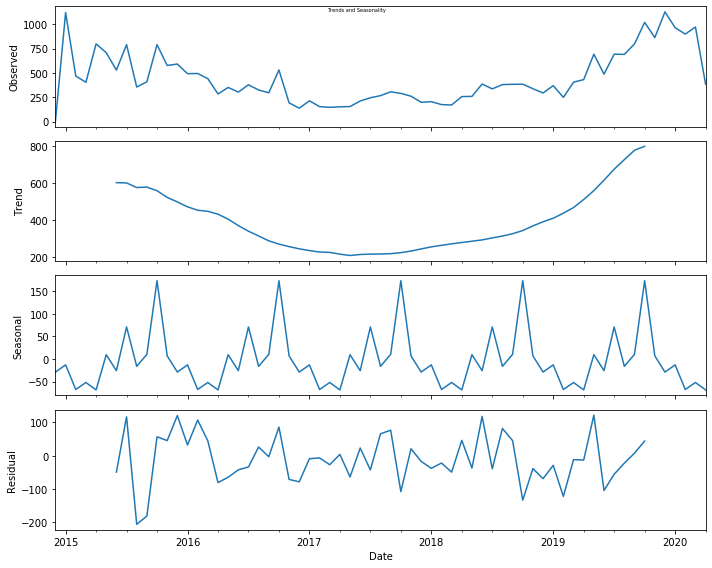

In [39]:
trend_seasonal(df,model='additive',titlesize=5,periode='M')

From there we clearly see that the pics on tweet_curve are observed arounr 2015 for the first one and 2020 for the second one. This is highly speaking because these years are years for american elections in US. We can then understand that he tweets more during these period in order to reach the maximum odience so that he can gain visibility and have a better position as a candidate.

The second observation is on the monthly seasonality, we observe that trump's tweets frequency is higher between Summer and automn, corresponding to the back to school for students and colleges, and end of holidays for workers.